Implementation of Tabular Dyna-Q algorithm in Dyna-Maze environment.

First i built the dyna maze myself to be able to use it in this project. 
there are two files in the project zip , named custome-env-for-dyna-q and dyna-q-env . 
in order to have dyna maze you should import these python files and create the environment using them .
keep in mind that the code must be run using pyhton files and jupyter notebook is only for display .

In [ ]:
import gymnasium as gym
from gymnasium.envs.registration import register
from gymnasium import spaces
from gymnasium.utils.env_checker import check_env

import Custom_Env_for_DynaQ as dynaqenv
import numpy as np

register(
    id='DynaQ-maze-v0',
    entry_point='Dyna_q_Env:DynaQ_World',
    kwargs={'grid_rows': 6, 'grid_cols': 9, 'obstacles': []}  
)

class DynaQ_World(gym.Env):
    metadata = {"render_modes":["human"], 'render_fps': 1}

    def __init__(self, grid_rows=6, grid_cols=9 ,obstacles=[], render_mode=None):
        
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        # self.target_pos = target_pos
        # self.agent_pos = agent_pos
        self.render_mode = render_mode

        self.world = dynaqenv.World(grid_rows=grid_rows,grid_cols=grid_cols,obstacles=obstacles)

        self.action_space = spaces.Discrete(len(dynaqenv.Action))

        self.observation_space = spaces.Box(
            low=0,
            high=np.array([self.grid_rows-1,self.grid_cols-1,self.grid_rows-1,self.grid_cols-1]),
            shape=(4,),
            dtype=np.int64
        )
    
    # def reset(self, seed=None, options=None,target_pos=[0,8],agent_pos=[2,0]):
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.world.reset(seed=seed)
        # self.world.reset(seed=seed,target_pos=target_pos,agent_pos=agent_pos)

        obs = np.concatenate((self.world.agent_pos,self.world.target_pos))

        info = {}

        if self.render_mode=='human':
            self.render()

        return obs, info
    
    def step(self,action):
        target_reached =self.world.perform_action(dynaqenv.Action(action))

        reward=0
        terminated=False
        if target_reached:
            reward=1
            terminated=True

        obs = np.concatenate((self.world.agent_pos,self.world.target_pos))

        info = {}

        if self.render_mode=='human':
            print(dynaqenv.Action(action))
            self.render()
        
        return obs, reward, terminated, False,info
    
    def render(self):
        self.world.render()

# if __name__=="__main__":
#     custom_obstacles = [[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8]]
#     env = gym.make('DynaQ-maze-v0',render_mode='human',grid_rows=6,grid_cols=9,obstacles=custom_obstacles)

#     print("Check environment begin")
#     check_env(env.unwrapped)
#     print("Check environment end")

#     obs = env.reset()[0]

#     for i in range(10):
#         rand_action = env.action_space.sample()
#         obs, reward, terminated, _,_=env.step(rand_action)

In [41]:
import random
from enum import Enum
import copy

class Action(Enum):
    LEFT=0
    DOWN=1
    RIGHT=2
    UP=3

class GridTile(Enum):
    _Floor=0
    OAgent=1
    Target=2
    Xobstacle=3

    def __str__(self):
        return self.name[:1]

class World:

    # obstacles_1 = [[1,0],[1,1],[1,2],[1,3],[1,4],[1,5],[1,6],[1,7]]
    # obstacles_2 = [[1,4],[1,3],[1,2],[1,1]]
    # obstacles_3 = [[1,0],[1,1],[1,2],[1,3],[1,4],[1,5],[1,6],[1,7],[2,5],[3,8],[4,7],[4,6],[4,8]]
    # shortcut = [[3,0],[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7]]
    # shortcut_shifted = [[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8]]
    # dyna_maze_8_1 = [[1,2],[2,2],[3,2],[4,5],[0,7],[1,7],[2,7]]
    def __init__(self,grid_rows=6,grid_cols=9,obstacles=[]):
        self.grid_rows=grid_rows
        self.grid_cols=grid_cols
        self.obstacle_pos = obstacles
        self.reset()


    def reset(self,seed=None):
        
        # self.agent_pos = [0,0]
        # self.agent_pos = [2,0] # for dyna maze
        self.agent_pos = [5,3] # for shift

        random.seed(seed)
        self.target_pos = [
        # #     # random.randint(1,self.grid_rows-1),
        # #     # random.randint(1,self.grid_cols-1)
        # #     # self.grid_rows-1,self.grid_cols-1
            0,8 # for dyna maze and shift
        ]


    def perform_action(self, agent_action:Action) -> bool:

        _ = self.agent_pos.copy()

        match agent_action :
            case Action.LEFT:
                if self.agent_pos[1]>0:
                    _[1]-=1
                    if not(self.obstacle_pos.__contains__(_)):
                        self.agent_pos[1]-=1
            case Action.RIGHT:
                if self.agent_pos[1]<self.grid_cols-1:
                    _[1]+=1
                    if not(self.obstacle_pos.__contains__(_)):
                        self.agent_pos[1]+=1
            case Action.DOWN:
                if self.agent_pos[0]<self.grid_rows-1:
                    _[0]+=1
                    if not(self.obstacle_pos.__contains__(_)):
                        self.agent_pos[0]+=1
            case Action.UP:
                if self.agent_pos[0]>0:
                    _[0]-=1
                    if not(self.obstacle_pos.__contains__(_)):
                        self.agent_pos[0]-=1

        return self.agent_pos == self.target_pos

    def render(self):

        for r in range(self.grid_rows):
            for c in range(self.grid_cols):

                if self.obstacle_pos.__contains__([r,c]):
                    print(GridTile.Xobstacle, end='')

                else:
                    match [r,c] :
                        case self.agent_pos:
                            print(GridTile.OAgent, end='')
                        case self.target_pos:
                            print(GridTile.Target, end='')
                        case _:
                            print('.', end='')

            print()
        print()



# if __name__=="__main__":
#     world = World()
#     world.render()
    
#     for i in range(25):
#         rand_action = random.choices(list(Action))
#         print(rand_action)

#         world.perform_action(rand_action)

#         world.render()

After creating the environment we will deploy dyna-q and dyna-q+ .

First we condisder dyna-q for first question .

Training********
Episode 0
.......XT
..X....X.
..X....X.
..X......
.....X...
...O.....

Action.RIGHT
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X....X.
..X......
.....X...
....O....

Action.DOWN
.......XT
..X....X.
..X

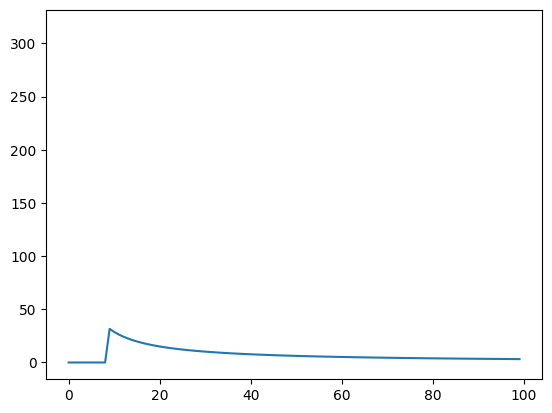

In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import os
import Dyna_q_Env

def run_q_learning(episodes,is_training=True,render=False,q_table=[]):
    
    env = gym.make('DynaQ-maze-v0',render_mode='human' if render else None)

    if is_training:
        q = np.zeros((env.unwrapped.grid_rows,env.unwrapped.grid_cols,env.unwrapped.grid_rows,env.unwrapped.grid_cols,env.action_space.n))
        model = {}
    else:
        q = q_table
        f = open('q_table.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    
    
    a = 0.9
    gamma = 0.9
    epsilon = 1

    a_prime = 0.6
    gamma_prime = 0.9

    steps_per_episode = np.zeros(episodes)

    step_count = 0
    for i in range(episodes):
        if(render):
            print(f'Episode {i}')

        state = env.reset()[0]
        terminated = False

        while not terminated:

            if is_training and random.random() < epsilon:

                action = env.action_space.sample()
            
            else:
                q_state_idx = tuple(state)

                action = np.argmax(q[q_state_idx])

            new_state , reward , terminated , _ , _ = env.step(action)

            q_state_action_idx = tuple(state) + (action,)

            q_new_state_idx = tuple(new_state)

            if is_training:
                q[q_state_action_idx] = q[q_state_action_idx] + a* (reward + gamma* np.max(q[q_new_state_idx]) - q[q_state_action_idx])
                model[(tuple(state),action)] = (reward, new_state)


                #loop for model learning
                for i in range(10):
                    
                    s,a = random.choice(list(model.keys()))
                    r, s_prime = model[(s,a)]
                    q_state_action_idx_m = s + (a,)
                    q_new_state_idx_m = tuple(s_prime)
                    q[q_state_action_idx_m] = q[q_state_action_idx_m] + a_prime * (r + gamma_prime * np.max(q[q_new_state_idx_m]) - q[q_state_action_idx_m])#could change alfa and gamma for model
            
                
            state = new_state

            step_count+=1
            if step_count>315:
                terminated = True
            if terminated:
                steps_per_episode[i] = step_count
                step_count = 0
            
        epsilon = max(epsilon - 1/episodes,0)
    
    env.close()

    # Graph steps
    sum_steps = np.zeros(episodes)
    for t in range(episodes):
        sum_steps[t] = np.mean(steps_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_steps)
    plt.savefig('img.png')

    if is_training:
        f = open("q_table.pkl","wb")
        pickle.dump(q, f)
        f.close()

    return q


if __name__=="__main__":
    print("Training********")
    q = run_q_learning(100,is_training=True,render=False)
    run_q_learning(1,is_training=False,render=True,q_table=q)

Here we applied dyna-q and for each loop in real environment the model loop 5 time using its model . we can see that the agent learn better and faster when using its model . by changing the number of n loops for model we can control how much the model , explore its own toughts . 
From graph we can see that after few episodes the steps required to reach to goal decrease fastly . We can deduce from it , that using an internal model for agent helped to generelize the problem and find the answer fater . you can trace the optimal action of agent from the maze that i created . agent is represented with character 'O' , barricades are 'X' and the target symbole is 'T'.


keep in mind that by variating the hyperparameters such as alpha and gamma for env or alpha and gamma for model , n as in n time loop for model learning , steps per episode restriction and .... , we can change the act of agent and its training speed .

Comparison of Dyna-Q+ and Dyna-Q in an environment that will change after 2000 timesteps.

Now we change the env and answer the second question which is the comparison between dyna_q and dyna_q_+ .

First we will use dyna-q

In [25]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import os
import Dyna_q_Env

def run_q_learning(episodes,is_training=True,render=False,q_table=[]):

    shortcut = [[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7]]
    blocked = [[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8]]  
    

    if is_training:
        env = gym.make('DynaQ-maze-v0',render_mode='human' if render else None,obstacles=blocked)
        q = np.zeros((env.unwrapped.grid_rows,env.unwrapped.grid_cols,env.unwrapped.grid_rows,env.unwrapped.grid_cols,env.action_space.n))
        model = {}
    else:
        env = gym.make('DynaQ-maze-v0',render_mode='human' if render else None,obstacles=shortcut)
        q = q_table
        f = open('q_table.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    
    
    a = 0.5
    gamma = 0.8
    epsilon = 1

    a_prime = 0.5
    gamma_prime = 0.8

    steps_per_episode = np.zeros(episodes)

    step_count = 0
    total_steps=0
    flag=True
    for i in range(episodes):
        if total_steps>2000 and flag:
            env = gym.make('DynaQ-maze-v0',render_mode='human' if render else None,obstacles=shortcut)#change env
            flag == False
        if(render):
            print(f'Episode {i}')

        state = env.reset()[0]
        terminated = False

        while not terminated:

            if is_training and random.random() < epsilon:

                action = env.action_space.sample()
            
            else:
                q_state_idx = tuple(state)

                action = np.argmax(q[q_state_idx])
            

            new_state , reward , terminated , _ , _ = env.step(action)
            
            q_state_action_idx = tuple(state) + (action,)

            q_new_state_idx = tuple(new_state)

            if is_training:
                q[q_state_action_idx] = q[q_state_action_idx] + a* (reward + gamma* np.max(q[q_new_state_idx]) - q[q_state_action_idx])
                model[(tuple(state),action)] = (reward, new_state)


                #loop for model learning
                for i in range(10):
                    
                    s,a = random.choice(list(model.keys()))
                    r, s_prime = model[(s,a)]
                    q_state_action_idx_m = s + (a,)
                    q_new_state_idx_m = tuple(s_prime)
                    q[q_state_action_idx_m] = q[q_state_action_idx_m] + a_prime * (r + gamma_prime * np.max(q[q_new_state_idx_m]) - q[q_state_action_idx_m])#could change alfa and gamma for model
            
                
            state = new_state

            step_count+=1
            if step_count>315:
                terminated = True
            if terminated:
                steps_per_episode[i] = step_count
                total_steps += step_count
                step_count = 0
            
            
        epsilon = max(epsilon - 1/episodes,0)
    
    env.close()

    if is_training:
        f = open("q_table.pkl","wb")
        pickle.dump(q, f)
        f.close()

    return q


if __name__=="__main__":
    print("Training********")
    q = run_q_learning(50,is_training=True,render=False)
    run_q_learning(1,is_training=False,render=True,q_table=q)

Training********
Episode 0
........T
.........
.........
.XXXXXXX.
.........
...O.....

Action.UP
........T
.........
.........
.XXXXXXX.
...O.....
.........

Action.LEFT
........T
.........
.........
.XXXXXXX.
..O......
.........

Action.LEFT
........T
.........
.........
.XXXXXXX.
.O.......
.........

Action.LEFT
........T
.........
.........
.XXXXXXX.
O........
.........

Action.UP
........T
.........
.........
OXXXXXXX.
.........
.........

Action.UP
........T
.........
O........
.XXXXXXX.
.........
.........

Action.RIGHT
........T
.........
.O.......
.XXXXXXX.
.........
.........

Action.UP
........T
.O.......
.........
.XXXXXXX.
.........
.........

Action.UP
.O......T
.........
.........
.XXXXXXX.
.........
.........

Action.RIGHT
..O.....T
.........
.........
.XXXXXXX.
.........
.........

Action.RIGHT
...O....T
.........
.........
.XXXXXXX.
.........
.........

Action.RIGHT
....O...T
.........
.........
.XXXXXXX.
.........
.........

Action.RIGHT
.....O..T
.........
.........

We can see that while a new shortcut appeared after 2000 steps which means shorter path to target , dyna-q didnt even noticed it as it stuck with the strategy it learned before . Thus we could say dyna-q wont perform well , when have a environment that change over time . 

Now we observe behaviour of dyna-q-+ for the same problem .

In [23]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import os
import Dyna_q_Env

def run_q_learning(episodes,is_training=True,render=False,q_table=[]):

    shortcut = [[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7]]
    blocked = [[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8]]
    
    

    if is_training:
        env = gym.make('DynaQ-maze-v0',render_mode='human' if render else None,obstacles=blocked)
        q = np.zeros((env.unwrapped.grid_rows,env.unwrapped.grid_cols,env.unwrapped.grid_rows,env.unwrapped.grid_cols,env.action_space.n))
        model = {}
    else:
        env = gym.make('DynaQ-maze-v0',render_mode='human' if render else None,obstacles=shortcut)
        q = q_table
        f = open('q_table.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    
    
    a = 0.9
    gamma = 0.9
    epsilon = 0.5

    a_prime = 0.6
    gamma_prime = 0.9

    steps_per_episode = np.zeros(episodes)

    step_count = 0
    total_steps=0
    flag=True
    for i in range(episodes):
        observed = []# here we will check when the state was observed
        if total_steps>2000 and flag:
            env = gym.make('DynaQ-maze-v0',render_mode='human' if render else None,obstacles=shortcut)#change env
            flag == False
        if(render):
            print(f'Episode {i}')

        state = env.reset()[0]
        terminated = False

        while not terminated:

            if is_training and random.random() < epsilon:

                action = env.action_space.sample()
                observed.append((state,step_count))
            
            else:
                q_state_idx = tuple(state)

                action = np.argmax(q[q_state_idx])
            

            new_state , reward , terminated , _ , _ = env.step(action)
            
            # Find the tuple (state, i) in the observed list
            matching_tuple = [(s, idx) for (s, idx) in observed if np.array_equal(s, state)]

            # Extract toe if the tuple is found
            if matching_tuple:
                toe = step_count - matching_tuple[-1][1]
            else:
                toe = 0

            reward += 0.1 * np.sqrt(toe)

            q_state_action_idx = tuple(state) + (action,)

            q_new_state_idx = tuple(new_state)

            if is_training:
                q[q_state_action_idx] = q[q_state_action_idx] + a* (reward + gamma* np.max(q[q_new_state_idx]) - q[q_state_action_idx])
                model[(tuple(state),action)] = (reward, new_state)


                #loop for model learning
                for i in range(10):
                    
                    s,a = random.choice(list(model.keys()))
                    r, s_prime = model[(s,a)]
                    q_state_action_idx_m = s + (a,)
                    q_new_state_idx_m = tuple(s_prime)
                    q[q_state_action_idx_m] = q[q_state_action_idx_m] + a_prime * (r + gamma_prime * np.max(q[q_new_state_idx_m]) - q[q_state_action_idx_m])#could change alfa and gamma for model
            
                
            state = new_state

            step_count+=1
            if step_count>1000:
                terminated = True
            if terminated:
                steps_per_episode[i] = step_count
                total_steps += step_count
                step_count = 0
            
            
        epsilon = max(epsilon - 1/episodes,0)
    
    env.close()

    if is_training:
        f = open("q_table.pkl","wb")
        pickle.dump(q, f)
        f.close()

    return q


if __name__=="__main__":
    print("Training********")
    q = run_q_learning(100,is_training=True,render=False)
    run_q_learning(1,is_training=False,render=True,q_table=q)

Training********
Episode 0
........T
.........
.........
.XXXXXXX.
.........
...O.....

Action.UP
........T
.........
.........
.XXXXXXX.
...O.....
.........

Action.RIGHT
........T
.........
.........
.XXXXXXX.
....O....
.........

Action.RIGHT
........T
.........
.........
.XXXXXXX.
.....O...
.........

Action.RIGHT
........T
.........
.........
.XXXXXXX.
......O..
.........

Action.RIGHT
........T
.........
.........
.XXXXXXX.
.......O.
.........

Action.RIGHT
........T
.........
.........
.XXXXXXX.
........O
.........

Action.UP
........T
.........
.........
.XXXXXXXO
.........
.........

Action.UP
........T
.........
........O
.XXXXXXX.
.........
.........

Action.UP
........T
........O
.........
.XXXXXXX.
.........
.........

Action.UP
........O
.........
.........
.XXXXXXX.
.........
.........



We can see that after a while dyna-q-+ will adapt to the new environment as the bonus reward is trying to make the agent explore states that was not observed for a while . So we can deduce that in changing environments , dyna-q-+ is far more efficient than dyna-q . But also there is additional cost of exploration that we must pay but it is acceptable trade-off.

Also i observed that for dyna-q-+ as the toe induce exploration , it is possible that the model do not learn well while using high epsilon value for epsilon greedy . so i reduced epsilon and then the model start to learn the right passage to the target.
Also observed that changing the value of k will give us the ability to induce or reduce exploration . For example k=1 means the highest curiosity which will result in total exploration. Exploration by bonus is different from exploration by epsilon greedy as the bonus exploration goal is to observe non-recent states which will robust the strategy to change in environment while epsilon greedy exploration is purly random so we do not get stuck in local optimums.

Comparison between Dyna-Q+ idea with Entropy-Regularized Reinforcement Learning 

Both dyna-q-+ and entropy-regularized reinforcment learning try to enhance exploration .Dyna-q-+ does this through exploration bonus to encourage visiting less frequent states while entropy-regularized reinforcment learning uses entropy maximization to promote diverse exploration .
Dyna-q-+ is not stochastic but the entropy-regularized reinforcment learning encourage stochastic policies which lead to better exploration .

Entropy-regularized reinforcment learning(Soft-Actor-Critic) , aims to maximize expected reward and entropy of the policy . The key idea is to Maximize entropy objective , Policy improvement , Off-policy learning.